In [1]:
!pip install -r requirements.txt

In [2]:
!python download_data.py

/home/valitar/Documents/M2DS/DataCamp/scmark-classification-etoiles/data directory is not empty. Please empty it or select another destination for LOCAL_DATA if you wish to proceed


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 13551), (1000,), (500, 13551), (500,))

## Labels

In [6]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
Name: proportion, dtype: float64

<Axes: >

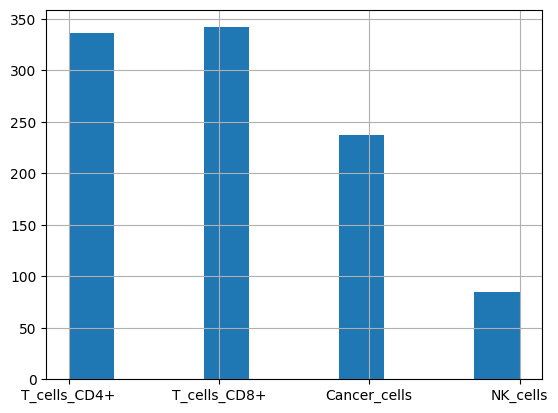

In [7]:
lab_df.label.hist()

### Oversampling

In [8]:
# ### Oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
X_resampled.shape, y_resampled.shape

((1368, 13551), (1368,))

<Axes: >

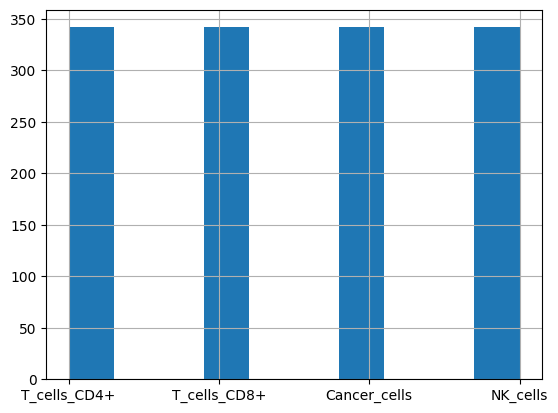

In [9]:
lab_df_resampled = pd.DataFrame({'label': y_resampled})
lab_df_resampled.label.hist()

## Tests sur PCA selon n_components

## resampled

In [10]:
type(X_resampled)
X_resampled_dense = X_resampled.toarray()

In [11]:
from sklearn.decomposition import PCA
var = []
for k in range(2, 50):
    pca = PCA(n_components=k)
    X_pca_resampled = pca.fit_transform(X_resampled_dense)
    # afficher la variance expliquée
    explained_variance = pca.explained_variance_ratio_
    var.append(explained_variance.sum())


In [12]:
X_pca_resampled.shape

(1368, 49)

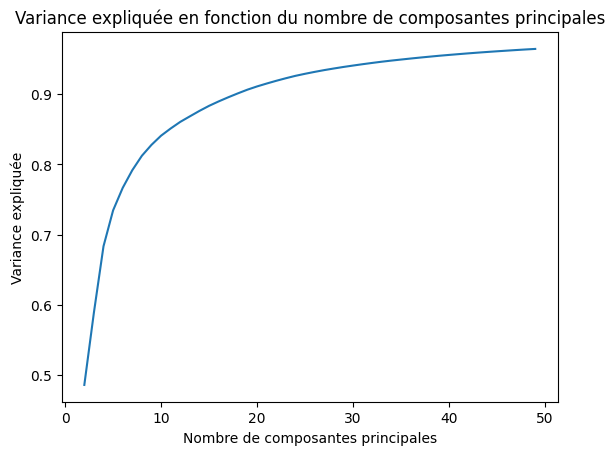

In [13]:
# afficher avec matplotlib
plt.plot(range(2, 50), var)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée en fonction du nombre de composantes principales')
plt.show()

## sans resample

In [14]:
from sklearn.decomposition import PCA
var = []
for k in range(2, 50):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_train)
    # afficher la variance expliquée
    explained_variance = pca.explained_variance_ratio_
    var.append(explained_variance.sum())


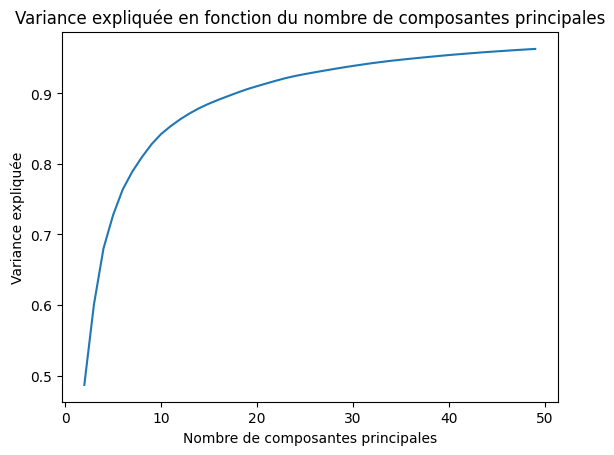

In [15]:
# afficher avec matplotlib
plt.plot(range(2, 50), var)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée en fonction du nombre de composantes principales')
plt.show()

In [17]:
# on modifie X_train pour passer de csr_matrix à DataFrame
X_train = pd.DataFrame(X_train.toarray())
X_test = pd.DataFrame(X_test.toarray())

In [18]:
# pour chaque gène la variance de leur expression sur chaque cellule

gene_variances = X_train.var(axis=0)
# trier les gènes par variance décroissante
sorted_genes = np.argsort(gene_variances)[::-1]
# sélectionner les 50 gènes les plus variables
top_genes = sorted_genes[:50]
# réduire X_train et X_test aux 50 gènes les plus variables
X_train_top = X_train.iloc[:, top_genes]
X_test_top = X_test.iloc[:, top_genes]

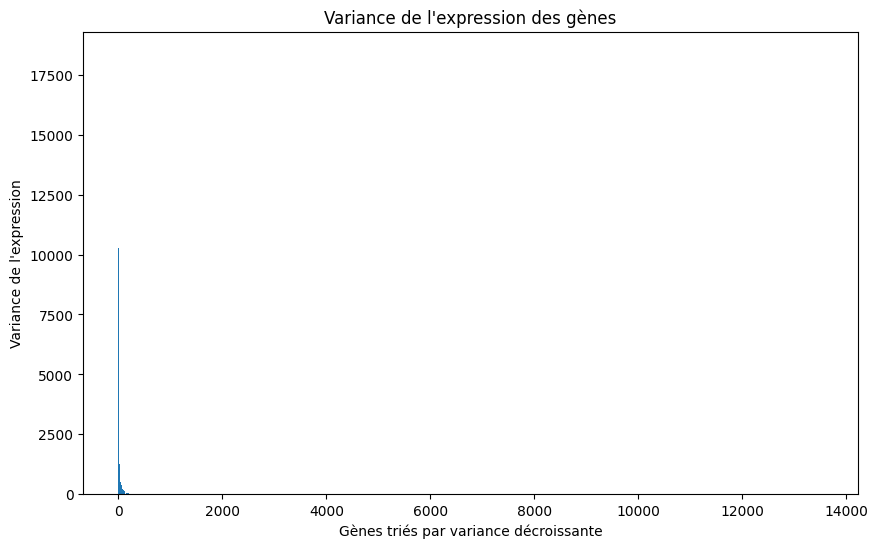

In [19]:
# afficher les gènes dans un graphe en fonction de leur variance de leur expression
plt.figure(figsize=(10, 6))
plt.bar(range(len(gene_variances)), sorted(gene_variances, reverse=True))
plt.xlabel('Gènes triés par variance décroissante')
plt.ylabel('Variance de l\'expression')
plt.title('Variance de l\'expression des gènes')
plt.show()

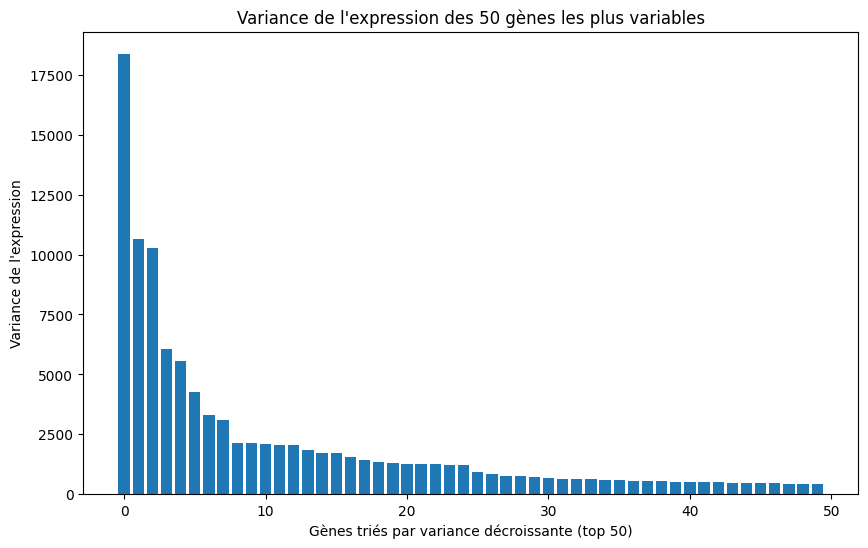

In [20]:
# meme chose mais sur les 5000 gènes les plus variables
plt.figure(figsize=(10, 6))
plt.bar(range(len(X_train_top.var(axis=0))), sorted(X_train_top.var(axis=0), reverse=True))
plt.xlabel('Gènes triés par variance décroissante (top 50)')
plt.ylabel('Variance de l\'expression')
plt.title('Variance de l\'expression des 50 gènes les plus variables')
plt.show()

## visualisation

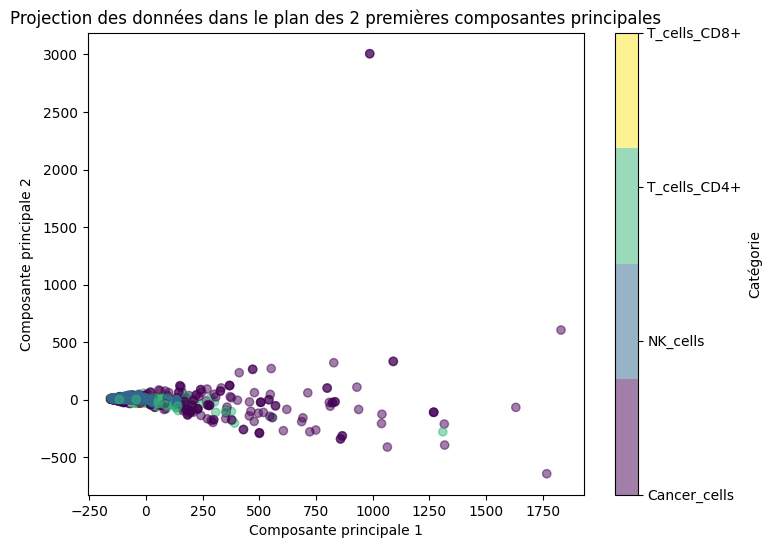

In [21]:
from matplotlib.colors import ListedColormap

# Créer un mapping des catégories à des indices numériques
categories = np.unique(y_resampled)
category_to_color = {category: idx for idx, category in enumerate(categories)}

# Mapper les catégories de y_resampled à des indices numériques
y_colors = np.array([category_to_color[label] for label in y_resampled])

# Définir une palette de couleurs
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(categories))))

# Tracer le graphique avec les couleurs mappées
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_resampled[:, 0], X_pca_resampled[:, 1], c=y_colors, cmap=cmap, alpha=0.5)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection des données dans le plan des 2 premières composantes principales')
plt.colorbar(scatter, ticks=range(len(categories)), label='Catégorie').ax.set_yticklabels(categories)
plt.show()

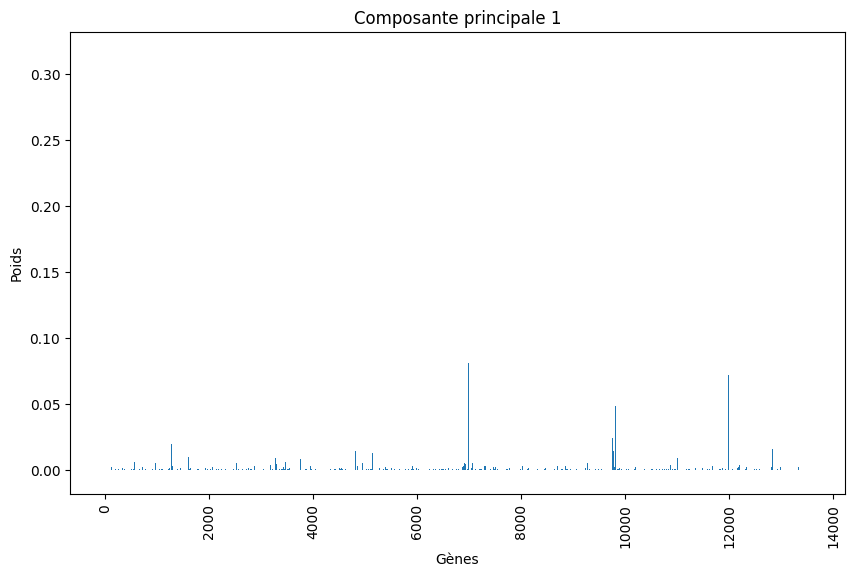

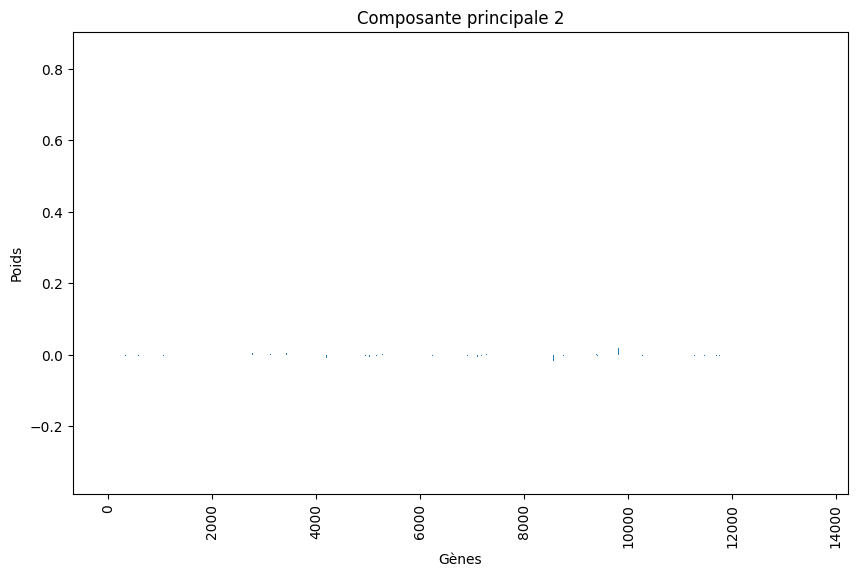

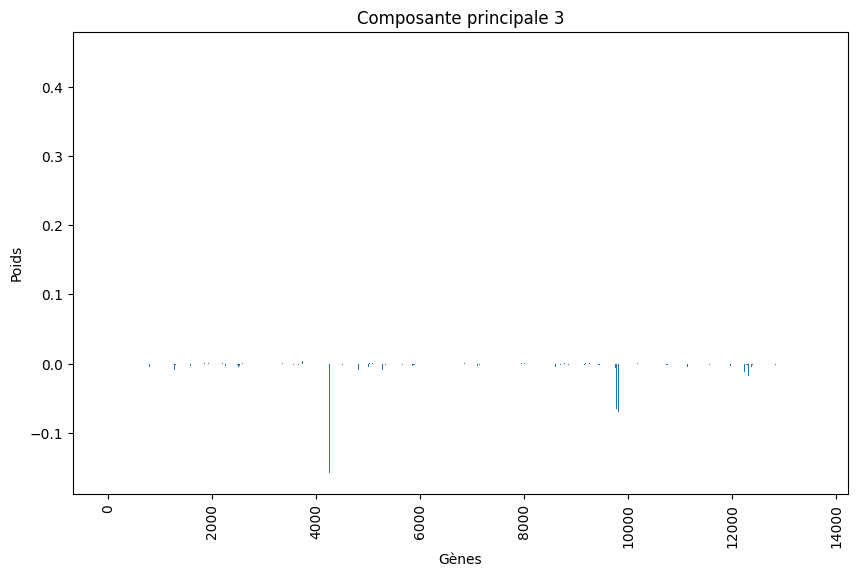

In [22]:
# on souhaite voir les genes les plus importants dans les composantes principales en affichant des barplots
# on commence par passer les X_train de csr_matrix à DataFrame
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_train)
components = pca.components_
genes = X_train.columns
for i in range(3):  # afficher les 3 premières composantes
    plt.figure(figsize=(10, 6))
    plt.bar(genes, components[i])
    plt.xlabel('Gènes')
    plt.ylabel('Poids')
    plt.title(f'Composante principale {i+1}')
    plt.xticks(rotation=90)
    plt.show()



# On essaie sur l'entraînement

In [23]:
from sklearn.metrics import balanced_accuracy_score

In [24]:
# this custom class is used by the challenge and calls 
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

In [27]:
type(X_train)

pandas.core.frame.DataFrame

In [29]:
def preprocess_X(X):
    # Conversion robuste en numpy array
    if hasattr(X, "toarray"):          # cas sparse
        X = X.toarray()
    elif hasattr(X, "values"):         # cas DataFrame
        X = X.values
    else:                              # cas déjà numpy
        X = np.asarray(X)

    row_sums = X.sum(axis=1)

    # éviter division par zéro
    row_sums[row_sums == 0] = 1

    X_norm = X / row_sums[:, np.newaxis]
    return X_norm

X_train_norm = preprocess_X(X_train) # modifier ici
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

True

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=20)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=5, n_estimators=100, max_features=3
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 50 components', PCA(n_components=20)),
                ('Random Forest Classifier',
                 RandomForestClassifier(max_depth=5, max_features=3))])

In [31]:
# fit on train
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.681
Test balanced accuracy : 0.580


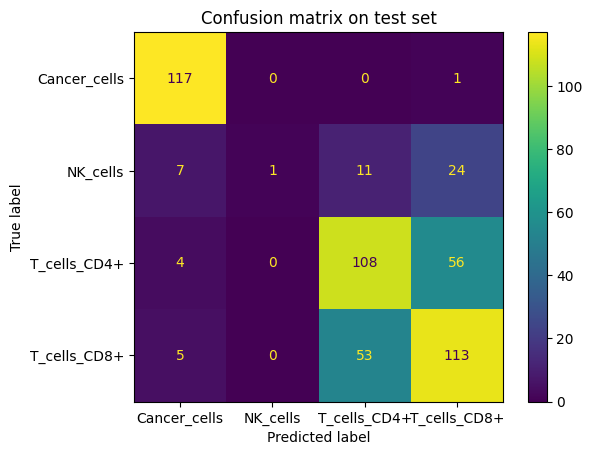

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")